In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import torch
import sys
sys.path.insert(1, '/home/nicolas/code/src')
sys.path.insert(1, '/home/nicolas/code/data')

from TMCRBM import TMCRBM
from scipy.integrate import simps
from scipy import stats
import h5py

device = torch.device("cuda")
dtype = torch.float
torch.set_num_threads(4)

In [2]:
data = torch.tensor(np.genfromtxt('../dataset/data_2d.dat'), device = device, dtype = dtype)

data = (data+1)/2

In [3]:
f = h5py.File("../model/AllParametersTMC2DRBM_NGibbs_30_Nh100_Nv1000_Nmb200_Nepoch100_lr_0.1_N20000_Npoint2500_Nchain10.h5", 'r')
alltimes = np.array(f['alltime'])
alltimes = []
for t in f['alltime'][:]:
    if 'W'+str(t) in f:
        alltimes.append(t)

In [4]:
t = alltimes[-1]
lr = 0.01
NGibbs = 100
annSteps = 0
mb_s = 600
num_pcd = 100
Nh = torch.tensor(f['W0']).shape[0]
Nv = data.shape[1]
ep_max = 10
w_hat = torch.linspace(0,1,steps=100)
_, S_d, V = torch.svd(data)
V0 = V[:,0]
N = 20000
it_mean = 50

In [5]:
myRBM = TMCRBM(num_visible=Nv,
            num_hidden=Nh,
            device=device,
            lr=lr,
            gibbs_steps=NGibbs,
            UpdCentered=False,
            mb_s=mb_s,
            num_pcd=num_pcd,
            N = N,
            it_mean = it_mean,
           )

In [6]:
myRBM.W = torch.tensor(f['W'+str(t)], device = myRBM.device)
myRBM.hbias = torch.tensor(f['hbias'+str(t)], device = myRBM.device)
myRBM.vbias = torch.tensor(f['vbias'+str(t)], device = myRBM.device)
myRBM.p_m = torch.tensor(f['p_m'+str(t)], device = myRBM.device)
_, _, V_g = torch.svd(myRBM.W)
if torch.mean(V_g[:,0])<0:
    V_g = -V_g
proj_data = torch.mm(data, V_g).cpu()/myRBM.Nv**.5
width_plus = .2
xmin = proj_data[:,0].min()-width_plus
xmax = proj_data[:,0].max()+width_plus
ymin = proj_data[:,1].min()-width_plus
ymax = proj_data[:,1].max()+width_plus

In [7]:
vinit = torch.bernoulli(torch.rand(
        (myRBM.Nv, 1000), device=myRBM.device, dtype=myRBM.dtype))
#vinit = torch.where(V_g[:,0]>0, 1, 0).repeat(2000).reshape(myRBM.Nv, 2000).float()
#vinit = data.T
si, _, _, _ = myRBM.Sampling(vinit, it_mcmc=10000)
proj_gen = torch.mm(si.T, V_g).cpu().numpy()/Nv**.5
proj_data = torch.mm(data, V_g).cpu().numpy()/Nv**.5

Text(0.5, 1.0, 'nb upd : 209')

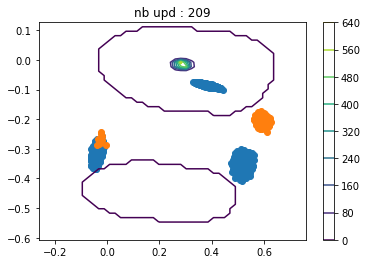

In [8]:
plt.scatter(proj_data[:,0], proj_data[:,1])
plt.scatter(proj_gen[:,0], proj_gen[:,1])
plt.contour((myRBM.p_m.cpu()), extent=[xmin, xmax, ymin, ymax])
plt.colorbar()
plt.title("nb upd : "+str(t))

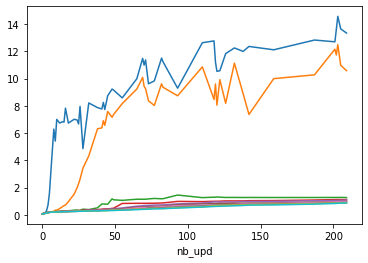

In [9]:
S = torch.zeros(10, len(alltimes), device = device)
for i in range(len(alltimes)):
    t = alltimes[i]
    _, tmpS, tmpV = torch.svd(torch.tensor(f['W'+str(t)], device = device))
    if torch.mean(tmpV[:,0])<0:
        tmpV = -tmpV
    #plt.plot(tmpV[:,0].cpu(), zorder=0)
    S[:,i] = tmpS[:10]
#plt.hlines(1/np.sqrt(1000), 0, 1000, color = 'black', zorder=10)
plt.plot(alltimes,S.T.cpu())
plt.xlabel("nb_upd");